I did some minimalistic testing for 3 other WES CNV tools, which all work for a cohort, like XHMM. Let's see how their general results compare to what we see in XHMM, and then we can have separate notebooks to play with parameters for each tool individually. Note that most of the code I'll be running in separate terminals, because they either take too long to run, but mostly because at the time of writing the R kernel in Jupyter was broken.

# ExomeCopy (R)

In [ ]:
%%R

library(exomeCopy)
target.file <- "/data/NCR_SBRB/simplex/SeqCapEZ_Exome_v3.0_Design_Annotation_files/SeqCap_EZ_Exome_v3_hg19_capture_targets.bed"
setwd('~/data/cnv/BAM')
bam.files <- list.files(pattern=".bam$")
keep_me = bam.files != 'CLIA_400168.bam' & bam.files != 'CLIA_400169.bam'
bam.files = bam.files[keep_me]
sample.names = strtrim(bam.files, 11)
reference.file <- "/fdb/igenomes/Homo_sapiens/UCSC/hg19/Sequence/BWAIndex/genome.fa"
target.df <- read.delim(target.file, header = FALSE)
target <- GRanges(seqname = target.df[, 1], IRanges(start = target.df[, 2] + 1, end = target.df[, 3]))
counts <- target
for (i in 1:length(bam.files)) {
    print(i)
    mcols(counts)[[sample.names[i]]] <- countBamInGRanges(bam.files[i], target)
}
counts$GC <- getGCcontent(target, reference.file)
counts$GC.sq <- counts$GC^2
counts$bg <- generateBackground(sample.names, counts, median)
counts$log.bg <- log(counts$bg + 0.1)
counts$width <- width(counts)
seqnames = sapply(1:22, function(d) sprintf('chr%d', d))

for (seqname in seqnames) {
    df = as.data.frame(counts[seqnames(counts) == seqname])
    for (sample in sample.names) {
        nzeros = sum(df[sample] == 0)
        pct0 = nzeros/nrow(df)
        if (pct0 > .9) {
            print(sprintf('%s in %s looks bad', sample, seqname))
        }
    }
}
    
runExomeCopy <- function(sample.name, seqs, counts) {
    library(exomeCopy) # each cpu needs to load ExomeCopy and have a copy of counts
    lapply(seqs, function(seq.name) exomeCopy(counts[seqnames(counts) == seq.name], sample.name,
                                              X.names = c("log.bg","GC", "GC.sq", "width"),
                                              S = 0:4, d = 2))
}
           
ncpus=10
library(parallel)
cl <- makeCluster(ncpus)
fit.list = parLapply(cl, sample.names, runExomeCopy, seqnames, counts)
stopCluster(cl)
res = compileCopyCountSegments(fit.list)
a = as.data.frame(res)
a = a[a$copy.count!=2,]
write.csv(a, file='~/data/cnv/exomeCopy/calls.txt', row.names=F)

# cn.mops (R)

In [ ]:
%%R

library(cn.mops)
setwd('~/data/cnv/BAM')
BAMFiles <- list.files(pattern=".bam$")
keep_me = BAMFiles != 'CLIA_400168.bam' & BAMFiles != 'CLIA_400169.bam'
BAMFiles = BAMFiles[keep_me]
segments <- read.table("/data/NCR_SBRB/simplex/SeqCapEZ_Exome_v3.0_Design_Annotation_files/SeqCap_EZ_Exome_v3_hg19_capture_targets.bed",sep="\t",as.is=TRUE)
gr <- GRanges(segments[,1],IRanges(segments[,2],segments[,3]))
X <- getSegmentReadCountsFromBAM(BAMFiles,GR=gr)
resCNMOPS <- exomecn.mops(X)
resCNMOPS <- calcIntegerCopyNumbers(resCNMOPS)
segm <- as.data.frame(segmentation(resCNMOPS))
CNVs <- as.data.frame(cnvs(resCNMOPS))
CNVRegions <- as.data.frame(cnvr(resCNMOPS))
write.csv(segm,file="/home/sudregp/data/cnv/cn.mops/segmentation.csv", row.names=F)
write.csv(CNVs,file="/home/sudregp/data/cnv/cn.mops/cnvs.csv", row.names=F)
write.csv(CNVRegions,file="/home/sudregp/data/cnv/cn.mops/cnvr.csv", row.names=F)

# CONiFER (Python downgraded environment)

In [4]:
cd ~/data/cnv/conifer
rm swarm*
cd ../BAM/
for i in `/bin/ls -1 *.bam`; do 
    echo "python /data/NCR_SBRB/software/conifer_v0.2.2/conifer.py rpkm --probes /data/NCR_SBRB/simplex/SeqCapEZ_Exome_v3.0_Design_Annotation_files/SeqCap_EZ_Exome_v3_hg19_capture_targets.bed --input /data/sudregp/cnv/BAM/${i} --output /data/sudregp/cnv/conifer/RPKM/${i}.rpkm.txt" >> ../conifer/swarm.rpkm;
done
cd ../conifer/
swarm -f swarm.rpkm --logdir trash --job-name rpkm --partition quick

57487530


In [2]:
cd ~/data/cnv/conifer

source activate my_py2.7
rm RPKM/CLIA_400168.bam* RPKM/CLIA_400169.bam*
python /data/NCR_SBRB/software/conifer_v0.2.2/conifer.py analyze \
    --probes /data/NCR_SBRB/simplex/SeqCapEZ_Exome_v3.0_Design_Annotation_files/SeqCap_EZ_Exome_v3_hg19_capture_targets.bed \
    --rpkm_dir ./RPKM/ --output analysis.hdf5 --svd 6 \
    --write_svals singular_values.txt --plot_scree screeplot.png \
    --write_sd sd_values.txt
python /data/NCR_SBRB/software/conifer_v0.2.2/conifer.py call \
    --input analysis.hdf5 --output calls.txt

(my_py2.7) (my_py2.7) (my_py2.7) (my_py2.7) [INIT] Successfully read in 368146 probes from /data/NCR_SBRB/simplex/SeqCapEZ_Exome_v3.0_Design_Annotation_files/SeqCap_EZ_Exome_v3_hg19_capture_targets.bed
[INIT] Found 97 RPKM files in ./RPKM/
[INIT] Mapping file to sampleID: ./RPKM/CLIA_400162.bam.rpkm.txt --> CLIA_400162.bam.rpkm
[INIT] Mapping file to sampleID: ./RPKM/CLIA_400166.bam.rpkm.txt --> CLIA_400166.bam.rpkm
[INIT] Mapping file to sampleID: ./RPKM/CLIA_400165.bam.rpkm.txt --> CLIA_400165.bam.rpkm
[INIT] Mapping file to sampleID: ./RPKM/CLIA_400167.bam.rpkm.txt --> CLIA_400167.bam.rpkm
[INIT] Mapping file to sampleID: ./RPKM/CLIA_400163.bam.rpkm.txt --> CLIA_400163.bam.rpkm
[INIT] Mapping file to sampleID: ./RPKM/CLIA_400161.bam.rpkm.txt --> CLIA_400161.bam.rpkm
[INIT] Mapping file to sampleID: ./RPKM/CLIA_400164.bam.rpkm.txt --> CLIA_400164.bam.rpkm
[INIT] Mapping file to sampleID: ./RPKM/CLIA_400190.bam.rpkm.txt --> CLIA_400190.bam.rpkm
[INIT] Mapping file to sampleID: ./RPKM/

[INIT] Mapping file to sampleID: ./RPKM/CLIA_400216.bam.rpkm.txt --> CLIA_400216.bam.rpkm
[INIT] Mapping file to sampleID: ./RPKM/CLIA_400212.bam.rpkm.txt --> CLIA_400212.bam.rpkm
[INIT] Mapping file to sampleID: ./RPKM/CLIA_400213.bam.rpkm.txt --> CLIA_400213.bam.rpkm
[INIT] Mapping file to sampleID: ./RPKM/CLIA_400214.bam.rpkm.txt --> CLIA_400214.bam.rpkm
[INIT] Mapping file to sampleID: ./RPKM/CLIA_400215.bam.rpkm.txt --> CLIA_400215.bam.rpkm
[INIT] Mapping file to sampleID: ./RPKM/CLIA_400211.bam.rpkm.txt --> CLIA_400211.bam.rpkm
[INIT] Mapping file to sampleID: ./RPKM/CLIA_400209.bam.rpkm.txt --> CLIA_400209.bam.rpkm
[INIT] Mapping file to sampleID: ./RPKM/CLIA_400210.bam.rpkm.txt --> CLIA_400210.bam.rpkm
[INIT] Successfully read RPKM data for sampleID: CCGO_800977.bam.rpkm
[INIT] Successfully read RPKM data for sampleID: CLIA_400127.bam.rpkm
[INIT] Successfully read RPKM data for sampleID: CLIA_400197.bam.rpkm
[INIT] Successfully read RPKM data for sampleID: CLIA_400129.bam.rpkm


  NaturalNameWarning )
/data/sudregp/python/envs/my_py2.7/lib/python2.7/site-packages/tables/path.py:98: NaturalNameWarning: object name is not a valid Python identifier: 'sample_CLIA_400127.bam.rpkm'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning )
/data/sudregp/python/envs/my_py2.7/lib/python2.7/site-packages/tables/path.py:98: NaturalNameWarning: object name is not a valid Python identifier: 'sample_CLIA_400197.bam.rpkm'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning )
/data/sudregp/python/envs/my_py2.7/lib/python2.7/site-packages/tables/path.py:98: NaturalNameWarning: object name is not a valid Python identifier: 'sample_CLIA_400129.bam.rpkm'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]

/data/sudregp/python/envs/my_py2.7/lib/python2.7/site-packages/tables/path.py:98: NaturalNameWarning: object name is not a valid Python identifier: 'sample_CLIA_400192.bam.rpkm'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning )
/data/sudregp/python/envs/my_py2.7/lib/python2.7/site-packages/tables/path.py:98: NaturalNameWarning: object name is not a valid Python identifier: 'sample_CLIA_400171.bam.rpkm'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning )
/data/sudregp/python/envs/my_py2.7/lib/python2.7/site-packages/tables/path.py:98: NaturalNameWarning: object name is not a valid Python identifier: 'sample_CLIA_400186.bam.rpkm'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be a

  NaturalNameWarning )
/data/sudregp/python/envs/my_py2.7/lib/python2.7/site-packages/tables/path.py:98: NaturalNameWarning: object name is not a valid Python identifier: 'sample_CLIA_400211.bam.rpkm'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning )
/data/sudregp/python/envs/my_py2.7/lib/python2.7/site-packages/tables/path.py:98: NaturalNameWarning: object name is not a valid Python identifier: 'sample_CLIA_400205.bam.rpkm'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning )
/data/sudregp/python/envs/my_py2.7/lib/python2.7/site-packages/tables/path.py:98: NaturalNameWarning: object name is not a valid Python identifier: 'sample_CLIA_400125.bam.rpkm'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]

/data/sudregp/python/envs/my_py2.7/lib/python2.7/site-packages/tables/path.py:98: NaturalNameWarning: object name is not a valid Python identifier: 'sample_CLIA_400209.bam.rpkm'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning )
/data/sudregp/python/envs/my_py2.7/lib/python2.7/site-packages/tables/path.py:98: NaturalNameWarning: object name is not a valid Python identifier: 'sample_CLIA_400194.bam.rpkm'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning )
/data/sudregp/python/envs/my_py2.7/lib/python2.7/site-packages/tables/path.py:98: NaturalNameWarning: object name is not a valid Python identifier: 'sample_CLIA_400198.bam.rpkm'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be a

  NaturalNameWarning )
/data/sudregp/python/envs/my_py2.7/lib/python2.7/site-packages/tables/path.py:98: NaturalNameWarning: object name is not a valid Python identifier: 'sample_CLIA_400137.bam.rpkm'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning )
/data/sudregp/python/envs/my_py2.7/lib/python2.7/site-packages/tables/path.py:98: NaturalNameWarning: object name is not a valid Python identifier: 'sample_CLIA_400196.bam.rpkm'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning )
/data/sudregp/python/envs/my_py2.7/lib/python2.7/site-packages/tables/path.py:98: NaturalNameWarning: object name is not a valid Python identifier: 'sample_CLIA_400136.bam.rpkm'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]

[RUNNING: chr20] Calculating median RPKM
[RUNNING: chr20] Masking 313 probes with median RPKM < 1.000000
[RUNNING: chr20] Calculating ZRPKM scores...
[RUNNING: chr20] SVD decomposition...
[RUNNING: chr20] Saving SVD-ZRPKM values
[RUNNING: chr21] Now on: chr21
[RUNNING: chr21] Found 3827 probes; probeID range is [222548-226375]
[RUNNING: chr21] Calculating median RPKM
[RUNNING: chr21] Masking 129 probes with median RPKM < 1.000000
[RUNNING: chr21] Calculating ZRPKM scores...
[RUNNING: chr21] SVD decomposition...
[RUNNING: chr21] Saving SVD-ZRPKM values
[RUNNING: chr22] Now on: chr22
[RUNNING: chr22] Found 8167 probes; probeID range is [226375-234542]
[RUNNING: chr22] Calculating median RPKM
[RUNNING: chr22] Masking 335 probes with median RPKM < 1.000000
[RUNNING: chr22] Calculating ZRPKM scores...
[RUNNING: chr22] SVD decomposition...
[RUNNING: chr22] Saving SVD-ZRPKM values
[RUNNING: chr23] Now on: chrX
[RUNNING: chr23] Found 13920 probes; probeID range is [352875-366795]
[RUNNING: chr

CLIA_400178.bam.rpkm	chr1	16975020	16975291	del
CLIA_400178.bam.rpkm	chr1	17263204	17270726	dup
CLIA_400188.bam.rpkm	chr1	12899896	12921619	del
CLIA_400188.bam.rpkm	chr1	12942877	12954838	del
CLIA_400188.bam.rpkm	chr1	34677779	35135190	del
CLIA_400188.bam.rpkm	chr1	17084025	17085525	dup
CLIA_400188.bam.rpkm	chr1	104112682	104160803	dup
CLIA_400179.bam.rpkm	chr1	146401577	146408207	del
CLIA_400179.bam.rpkm	chr1	25620535	25629790	dup
CLIA_400192.bam.rpkm	chr1	111906155	111933873	del
CLIA_400192.bam.rpkm	chr1	201868351	201869951	del
CLIA_400192.bam.rpkm	chr1	1644648	1645161	dup
CLIA_400192.bam.rpkm	chr1	17013235	17017577	dup
CLIA_400171.bam.rpkm	chr1	22313078	22336727	del
CLIA_400171.bam.rpkm	chr1	146403618	146409993	del
CLIA_400171.bam.rpkm	chr1	206241476	206331239	del
CLIA_400171.bam.rpkm	chr1	32605554	32623996	dup
CLIA_400171.bam.rpkm	chr1	117146216	117150768	dup
CLIA_400171.bam.rpkm	chr1	146241581	146249052	dup
CLIA_400186.bam.rpkm	chr1	13144382	13204065	del
CLIA_400186.bam.rpkm	chr1	

CLIA_400211.bam.rpkm	chr1	144516033	144612480	del
CLIA_400211.bam.rpkm	chr1	148349676	148737005	del
CLIA_400211.bam.rpkm	chr1	248737578	248790098	del
CLIA_400211.bam.rpkm	chr1	25598971	25633295	dup
CLIA_400211.bam.rpkm	chr1	26365596	26369265	dup
CLIA_400211.bam.rpkm	chr1	152185808	152190720	dup
CLIA_400211.bam.rpkm	chr1	158260909	158262670	dup
CLIA_400211.bam.rpkm	chr1	207010285	207039638	dup
CLIA_400211.bam.rpkm	chr1	231885609	231954961	dup
CLIA_400205.bam.rpkm	chr1	25611004	25628162	del
CLIA_400205.bam.rpkm	chr1	152760180	152770360	del
CLIA_400205.bam.rpkm	chr1	1580382	1631450	dup
CLIA_400205.bam.rpkm	chr1	1634526	1636320	dup
CLIA_400205.bam.rpkm	chr1	10336255	10352233	dup
CLIA_400205.bam.rpkm	chr1	152185808	152189528	dup
CLIA_400125.bam.rpkm	chr1	111926946	111933873	del
CLIA_400125.bam.rpkm	chr1	207700298	207706979	dup
CLIA_400125.bam.rpkm	chr1	207718572	207726287	dup
CLIA_400177.bam.rpkm	chr1	152759739	152770360	del
CLIA_400177.bam.rpkm	chr1	248737578	248790098	del
CLIA_400177.bam.

CLIA_400130.bam.rpkm	chr1	1634249	1636320	dup
CLIA_400130.bam.rpkm	chr1	1640134	1654278	dup
CLIA_400130.bam.rpkm	chr1	1656819	1671154	dup
CLIA_400130.bam.rpkm	chr1	17013080	17013953	dup
CLIA_400130.bam.rpkm	chr1	104161474	104164218	dup
CLIA_400130.bam.rpkm	chr1	104201976	104230317	dup
CLIA_400130.bam.rpkm	chr1	148942391	149263083	dup
CLIA_400130.bam.rpkm	chr1	149323264	149400460	dup
CLIA_400139.bam.rpkm	chr1	22315686	22336727	del
CLIA_400181.bam.rpkm	chr1	108918732	108963885	del
CLIA_400181.bam.rpkm	chr1	108995748	109000700	del
CLIA_400181.bam.rpkm	chr1	703847	762127	dup
CLIA_400181.bam.rpkm	chr1	16344394	16358753	dup
CLIA_400181.bam.rpkm	chr1	145293393	145298411	dup
CLIA_400166.bam.rpkm	chr1	1634856	1636320	dup
CLIA_400166.bam.rpkm	chr1	1640828	1670347	dup
CLIA_400166.bam.rpkm	chr1	87800629	87810627	dup
CLIA_400183.bam.rpkm	chr1	19236732	19282804	del
CLIA_400183.bam.rpkm	chr1	13427640	13449297	dup
CLIA_400183.bam.rpkm	chr1	184559763	184590641	dup
CLIA_400216.bam.rpkm	chr1	144621512	14

CLIA_400156.bam.rpkm	chr10	46552392	46651541	dup
CLIA_400156.bam.rpkm	chr10	46664178	46678761	dup
CLIA_400156.bam.rpkm	chr10	48738576	48827612	dup
CLIA_400156.bam.rpkm	chr10	48856017	48863476	dup
CLIA_400156.bam.rpkm	chr10	49260461	49272598	dup
CLIA_400156.bam.rpkm	chr10	49364117	49365465	dup
CLIA_400167.bam.rpkm	chr10	51465732	51469998	dup
CLIA_400157.bam.rpkm	chr10	70098877	70102546	del
CLIA_400157.bam.rpkm	chr10	51214469	51226440	dup
CLIA_400211.bam.rpkm	chr10	46898279	46904531	del
CLIA_400211.bam.rpkm	chr10	48909387	48922216	del
CLIA_400211.bam.rpkm	chr10	49087897	49088678	del
CLIA_400211.bam.rpkm	chr10	48236411	48236819	dup
CLIA_400205.bam.rpkm	chr10	88985501	88994976	del
CLIA_400205.bam.rpkm	chr10	47192279	47194279	dup
CLIA_400205.bam.rpkm	chr10	48047636	48188744	dup
CLIA_400205.bam.rpkm	chr10	48235069	48255527	dup
CLIA_400205.bam.rpkm	chr10	124359911	124375418	dup
CLIA_400125.bam.rpkm	chr10	46760119	46904531	del
CLIA_400125.bam.rpkm	chr10	48980350	49094588	del
CLIA_400125.bam.rp

CLIA_400190.bam.rpkm	chr11	18765522	18956186	dup
CLIA_400190.bam.rpkm	chr11	75298067	75314575	dup
CLIA_400190.bam.rpkm	chr11	85090095	85347324	dup
CLIA_400173.bam.rpkm	chr11	55340022	55419292	del
CLIA_400173.bam.rpkm	chr11	55432949	55451460	del
CLIA_400173.bam.rpkm	chr11	123909160	123965208	dup
CLIA_400143.bam.rpkm	chr11	55259196	55540950	del
CLIA_400143.bam.rpkm	chr11	89485945	89487009	dup
CLIA_400148.bam.rpkm	chr11	18955326	18956030	dup
CLIA_400123.bam.rpkm	chr11	5786402	5799947	del
CLIA_400123.bam.rpkm	chr11	5270907	5290871	dup
CLIA_400210.bam.rpkm	chr11	7817437	7818173	del
CLIA_400210.bam.rpkm	chr11	89786685	89791166	del
CLIA_400170.bam.rpkm	chr11	55340022	55418868	del
CLIA_400170.bam.rpkm	chr11	55433347	55451460	del
CLIA_400170.bam.rpkm	chr11	11964166	11990083	dup
CLIA_400170.bam.rpkm	chr11	55632972	55653764	dup
CLIA_400163.bam.rpkm	chr11	89595546	89644913	del
CLIA_400163.bam.rpkm	chr11	4254482	4308705	dup
CLIA_400163.bam.rpkm	chr11	89665856	89715000	dup
CLIA_400126.bam.rpkm	chr11

CLIA_400126.bam.rpkm	chr12	53494712	53499814	del
CLIA_400187.bam.rpkm	chr12	74245	88837	dup
CLIA_400187.bam.rpkm	chr12	9718862	9723534	dup
CLIA_400187.bam.rpkm	chr12	40791619	40814258	dup
CLIA_400182.bam.rpkm	chr12	10959273	10962392	dup
CLIA_400182.bam.rpkm	chr12	31269214	31348491	dup
CLIA_400164.bam.rpkm	chr12	11461072	11545763	dup
CLIA_400135.bam.rpkm	chr12	88406	88837	del
CLIA_400135.bam.rpkm	chr12	49121206	49161820	del
CLIA_400135.bam.rpkm	chr12	51600485	51636234	dup
CLIA_400135.bam.rpkm	chr12	78392017	78400931	dup
CLIA_400135.bam.rpkm	chr12	131622600	132032365	dup
CLIA_400175.bam.rpkm	chr12	9620237	9717995	dup
CLIA_400175.bam.rpkm	chr12	52680936	52779290	dup
CLIA_400175.bam.rpkm	chr12	68042837	68051110	dup
CLIA_400175.bam.rpkm	chr12	69084321	69103896	dup
CLIA_400175.bam.rpkm	chr12	133509729	133618106	dup
CLIA_400156.bam.rpkm	chr12	10572905	10586563	dup
CLIA_400156.bam.rpkm	chr12	31288979	31298516	dup
CLIA_400156.bam.rpkm	chr12	31300868	31302346	dup
CLIA_400156.bam.rpkm	chr12	31303

CLIA_400179.bam.rpkm	chr14	22935288	22947081	dup
CLIA_400179.bam.rpkm	chr14	22948433	22957714	dup
CLIA_400179.bam.rpkm	chr14	24586810	24590110	dup
CLIA_400179.bam.rpkm	chr14	93694063	93704261	dup
CLIA_400186.bam.rpkm	chr14	21269690	21424616	del
CLIA_400186.bam.rpkm	chr14	105411900	105412414	del
CLIA_400186.bam.rpkm	chr14	74009957	74036645	dup
CLIA_400186.bam.rpkm	chr14	107131323	107179022	dup
CLIA_400173.bam.rpkm	chr14	22636534	22690117	del
CLIA_400173.bam.rpkm	chr14	22928636	22935263	del
CLIA_400173.bam.rpkm	chr14	22951198	22955323	del
CLIA_400173.bam.rpkm	chr14	105415831	105416882	del
CLIA_400173.bam.rpkm	chr14	21678711	21679405	dup
CLIA_400173.bam.rpkm	chr14	106899370	106940441	dup
CLIA_400143.bam.rpkm	chr14	81743571	81744551	dup
CLIA_400148.bam.rpkm	chr14	20843887	20845965	dup
CLIA_400148.bam.rpkm	chr14	106805169	106816175	dup
CLIA_400123.bam.rpkm	chr14	20181357	20182098	dup
CLIA_400123.bam.rpkm	chr14	22891765	22908099	dup
CLIA_400123.bam.rpkm	chr14	106805351	106815723	dup
CLIA_400

CLIA_400150.bam.rpkm	chr15	85681600	85740026	dup
CLIA_400150.bam.rpkm	chr15	85741952	85747567	dup
CLIA_400150.bam.rpkm	chr15	85755328	85787279	dup
CLIA_400160.bam.rpkm	chr15	28899343	28903958	del
CLIA_400160.bam.rpkm	chr15	34786684	34819333	del
CLIA_400160.bam.rpkm	chr15	32685862	32692760	dup
CLIA_400160.bam.rpkm	chr15	32695284	32720525	dup
CLIA_400214.bam.rpkm	chr15	22742329	22743332	del
CLIA_400214.bam.rpkm	chr15	82635232	82636744	del
CLIA_400178.bam.rpkm	chr15	30436893	30437233	dup
CLIA_400178.bam.rpkm	chr15	102513157	102515379	dup
CLIA_400188.bam.rpkm	chr15	23303716	23317073	del
CLIA_400188.bam.rpkm	chr15	84857292	84859219	del
CLIA_400188.bam.rpkm	chr15	84859912	84868962	del
CLIA_400188.bam.rpkm	chr15	84906240	84907421	del
CLIA_400188.bam.rpkm	chr15	84975299	85057317	del
CLIA_400188.bam.rpkm	chr15	75552781	75558779	dup
CLIA_400188.bam.rpkm	chr15	75560558	75562184	dup
CLIA_400192.bam.rpkm	chr15	23263320	23286776	dup
CLIA_400192.bam.rpkm	chr15	28912846	28918973	dup
CLIA_400192.bam.rp

CLIA_400209.bam.rpkm	chr15	74367091	74370079	dup
CLIA_400209.bam.rpkm	chr15	75585357	75586644	dup
CLIA_400209.bam.rpkm	chr15	82933763	82939110	dup
CLIA_400209.bam.rpkm	chr15	82984309	82985119	dup
CLIA_400194.bam.rpkm	chr15	85737626	85739021	dup
CLIA_400194.bam.rpkm	chr15	85741567	85744688	dup
CLIA_400198.bam.rpkm	chr15	22448492	22473085	dup
CLIA_400198.bam.rpkm	chr15	32702709	32729857	dup
CLIA_400198.bam.rpkm	chr15	32894684	32908598	dup
CLIA_400189.bam.rpkm	chr15	85054690	85057317	dup
CLIA_400191.bam.rpkm	chr15	23285276	23316257	dup
CLIA_400191.bam.rpkm	chr15	23329926	23331121	dup
CLIA_400191.bam.rpkm	chr15	30419814	30430200	dup
CLIA_400191.bam.rpkm	chr15	32689128	32691072	dup
CLIA_400191.bam.rpkm	chr15	43309263	43320079	dup
CLIA_400191.bam.rpkm	chr15	50754385	50769642	dup
CLIA_400159.bam.rpkm	chr15	30406096	30420020	del
CLIA_400159.bam.rpkm	chr15	30431815	30434469	del
CLIA_400159.bam.rpkm	chr15	75584846	75586548	del
CLIA_400159.bam.rpkm	chr15	77940174	78189714	del
CLIA_400159.bam.rpkm

CLIA_400170.bam.rpkm	chr16	21547928	21559372	dup
CLIA_400170.bam.rpkm	chr16	22490202	22492542	dup
CLIA_400170.bam.rpkm	chr16	34682116	46551936	dup
CLIA_400163.bam.rpkm	chr16	16344724	16359076	del
CLIA_400163.bam.rpkm	chr16	21419243	21467772	del
CLIA_400163.bam.rpkm	chr16	21469200	21488140	del
CLIA_400163.bam.rpkm	chr16	21495053	21624157	del
CLIA_400163.bam.rpkm	chr16	22465966	22539018	del
CLIA_400163.bam.rpkm	chr16	22558230	22588036	del
CLIA_400151.bam.rpkm	chr16	16422791	16425593	del
CLIA_400151.bam.rpkm	chr16	18462006	18472885	del
CLIA_400151.bam.rpkm	chr16	18478253	18481318	dup
CLIA_400151.bam.rpkm	chr16	70164223	70170227	dup
CLIA_400126.bam.rpkm	chr16	70154320	70211352	dup
CLIA_400126.bam.rpkm	chr16	74386118	74422812	dup
CLIA_400187.bam.rpkm	chr16	16346226	16359076	del
CLIA_400187.bam.rpkm	chr16	28668107	28723151	dup
CLIA_400207.bam.rpkm	chr16	14982875	14995483	del
CLIA_400207.bam.rpkm	chr16	15039644	15123916	del
CLIA_400207.bam.rpkm	chr16	33326700	33414186	del
CLIA_400207.bam.rpkm

CLIA_400134.bam.rpkm	chr17	43555488	43611688	del
CLIA_400134.bam.rpkm	chr17	43617181	43627341	del
CLIA_400134.bam.rpkm	chr17	44270158	44374425	dup
CLIA_400134.bam.rpkm	chr17	44601157	44634724	dup
CLIA_400134.bam.rpkm	chr17	44720376	44788305	dup
CLIA_400202.bam.rpkm	chr17	18983612	19031058	dup
CLIA_400202.bam.rpkm	chr17	19042798	19122827	dup
CLIA_400202.bam.rpkm	chr17	43585591	43595774	dup
CLIA_400152.bam.rpkm	chr17	39422043	39427641	dup
CLIA_400152.bam.rpkm	chr17	44377055	44405927	dup
CLIA_400152.bam.rpkm	chr17	44421907	44592686	dup
CLIA_400152.bam.rpkm	chr17	44648011	44770471	dup
CLIA_400195.bam.rpkm	chr17	18927473	18967373	del
CLIA_400195.bam.rpkm	chr17	37898494	37900516	del
CLIA_400195.bam.rpkm	chr17	45422313	45452349	dup
CLIA_400200.bam.rpkm	chr17	18990955	18997375	del
CLIA_400200.bam.rpkm	chr17	44414576	44497386	del
CLIA_400200.bam.rpkm	chr17	44625945	44627251	del
CLIA_400200.bam.rpkm	chr17	44634648	44714972	del
CLIA_400200.bam.rpkm	chr17	43591265	43595955	dup
CLIA_400160.bam.rpkm

CLIA_400206.bam.rpkm	chr17	44630665	44634724	dup
CLIA_400199.bam.rpkm	chr17	40699573	40714534	del
CLIA_400199.bam.rpkm	chr17	44414936	44422081	del
CLIA_400199.bam.rpkm	chr17	44600383	44618296	del
CLIA_400122.bam.rpkm	chr17	16715734	16725363	del
CLIA_400122.bam.rpkm	chr17	18330495	18333214	dup
CLIA_400122.bam.rpkm	chr17	18353523	18387331	dup
CLIA_400130.bam.rpkm	chr17	44376875	44400350	dup
CLIA_400130.bam.rpkm	chr17	44430103	44564555	dup
CLIA_400139.bam.rpkm	chr17	18950088	18997027	dup
CLIA_400181.bam.rpkm	chr17	61937387	61986057	del
CLIA_400181.bam.rpkm	chr17	16723922	16725850	dup
CLIA_400181.bam.rpkm	chr17	34497839	34499376	dup
CLIA_400181.bam.rpkm	chr17	34799081	34800609	dup
CLIA_400181.bam.rpkm	chr17	43587583	43595955	dup
CLIA_400181.bam.rpkm	chr17	45105636	45127827	dup
CLIA_400181.bam.rpkm	chr17	57743803	57756964	dup
CLIA_400166.bam.rpkm	chr17	61950192	61958265	del
CLIA_400166.bam.rpkm	chr17	34522669	34542055	dup
CLIA_400166.bam.rpkm	chr17	34590100	34624931	dup
CLIA_400183.bam.rpkm

CLIA_400135.bam.rpkm	chr19	41351199	41354297	del
CLIA_400175.bam.rpkm	chr19	40399236	40399742	dup
CLIA_400175.bam.rpkm	chr19	43343417	43441290	dup
CLIA_400175.bam.rpkm	chr19	53513713	53553336	dup
CLIA_400156.bam.rpkm	chr19	53513713	53553336	dup
CLIA_400156.bam.rpkm	chr19	55247205	55255563	dup
CLIA_400156.bam.rpkm	chr19	55266405	55331507	dup
CLIA_400156.bam.rpkm	chr19	55351087	55359368	dup
CLIA_400167.bam.rpkm	chr19	52131337	52196630	dup
CLIA_400142.bam.rpkm	chr19	40376425	40380276	dup
CLIA_400157.bam.rpkm	chr19	40400238	40406105	del
CLIA_400157.bam.rpkm	chr19	104867	111168	dup
CLIA_400157.bam.rpkm	chr19	35842973	35851048	dup
CLIA_400211.bam.rpkm	chr19	7019107	7037882	dup
CLIA_400211.bam.rpkm	chr19	7040033	7051854	dup
CLIA_400211.bam.rpkm	chr19	51228283	51274481	dup
CLIA_400211.bam.rpkm	chr19	55489013	55494555	dup
CLIA_400125.bam.rpkm	chr19	43348400	43529286	del
CLIA_400177.bam.rpkm	chr19	43708875	43762678	del
CLIA_400177.bam.rpkm	chr19	4217743	4224520	dup
CLIA_400177.bam.rpkm	chr19	547

CLIA_400179.bam.rpkm	chr2	242841125	242946659	del
CLIA_400179.bam.rpkm	chr2	91842857	91873381	dup
CLIA_400171.bam.rpkm	chr2	38902998	38973954	dup
CLIA_400186.bam.rpkm	chr2	175450122	175622813	del
CLIA_400186.bam.rpkm	chr2	190738370	190788636	dup
CLIA_400190.bam.rpkm	chr2	130777013	130796841	del
CLIA_400190.bam.rpkm	chr2	132859877	132860748	del
CLIA_400190.bam.rpkm	chr2	152448432	152450840	dup
CLIA_400173.bam.rpkm	chr2	38956640	38972030	dup
CLIA_400173.bam.rpkm	chr2	43520205	43625313	dup
CLIA_400173.bam.rpkm	chr2	131220720	131232555	dup
CLIA_400173.bam.rpkm	chr2	190741941	190789511	dup
CLIA_400148.bam.rpkm	chr2	24535012	24881704	del
CLIA_400148.bam.rpkm	chr2	152435860	152440059	del
CLIA_400210.bam.rpkm	chr2	96564810	96572575	dup
CLIA_400210.bam.rpkm	chr2	99977865	99980274	dup
CLIA_400170.bam.rpkm	chr2	114242682	114299831	del
CLIA_400170.bam.rpkm	chr2	38956720	38972030	dup
CLIA_400170.bam.rpkm	chr2	130949572	130951889	dup
CLIA_400163.bam.rpkm	chr2	87149698	87169494	del
CLIA_400151.bam.rp

CLIA_400137.bam.rpkm	chr2	98162043	98168065	dup
CLIA_400196.bam.rpkm	chr2	210559629	210568700	dup
CLIA_400136.bam.rpkm	chr2	152948536	152977226	dup
CLIA_400136.bam.rpkm	chr2	160825691	160833916	dup
CLIA_400131.bam.rpkm	chr2	111137122	111157720	del
CLIA_400131.bam.rpkm	chr2	175462292	175619148	del
CLIA_400131.bam.rpkm	chr2	107039582	107040374	dup
CLIA_400131.bam.rpkm	chr2	110679268	110744949	dup
CLIA_400131.bam.rpkm	chr2	132008444	132021325	dup
CLIA_400131.bam.rpkm	chr2	179517517	179519460	dup
CLIA_400131.bam.rpkm	chr2	190738370	190788821	dup
CLIA_400155.bam.rpkm	chr2	27745291	27788870	del
CLIA_400155.bam.rpkm	chr2	131448983	131486996	del
CLIA_400155.bam.rpkm	chr2	131220890	131228099	dup
CLIA_400155.bam.rpkm	chr2	219692240	219695146	dup
CLIA_400153.bam.rpkm	chr2	89952771	90414298	del
CLIA_400153.bam.rpkm	chr2	90491148	91679329	del
CLIA_400153.bam.rpkm	chr2	91793465	91843100	del
CLIA_400197.bam.rpkm	chr20	1559034	1592193	dup
CLIA_400146.bam.rpkm	chr20	1552297	1559202	del
CLIA_400121.bam.

CLIA_400138.bam.rpkm	chr22	16436391	16449242	dup
CLIA_400215.bam.rpkm	chr22	42486518	42536700	dup
CLIA_400180.bam.rpkm	chr22	42952466	42978050	del
CLIA_400180.bam.rpkm	chr22	42898275	42951104	dup
CLIA_400154.bam.rpkm	chr22	18844764	18866082	dup
CLIA_400154.bam.rpkm	chr22	21562937	21570383	dup
CLIA_400154.bam.rpkm	chr22	24347095	24384266	dup
CLIA_400209.bam.rpkm	chr22	39358410	39382136	del
CLIA_400194.bam.rpkm	chr22	42486799	42525185	dup
CLIA_400198.bam.rpkm	chr22	16650498	16651680	dup
CLIA_400198.bam.rpkm	chr22	42608348	42609193	dup
CLIA_400189.bam.rpkm	chr22	50523053	50529889	dup
CLIA_400159.bam.rpkm	chr22	50635676	50647208	del
CLIA_400159.bam.rpkm	chr22	29450666	29469254	dup
CLIA_400206.bam.rpkm	chr22	37466618	37480925	dup
CLIA_400147.bam.rpkm	chr22	39357560	39388537	del
CLIA_400147.bam.rpkm	chr22	42522572	42524060	dup
CLIA_400199.bam.rpkm	chr22	39358179	39388393	del
CLIA_400122.bam.rpkm	chr22	20457310	20458100	del
CLIA_400122.bam.rpkm	chr22	21740358	21741879	dup
CLIA_400122.bam.rpkm

CLIA_400142.bam.rpkm	chr3	195453415	195461608	dup
CLIA_400157.bam.rpkm	chr3	75440811	75648476	del
CLIA_400205.bam.rpkm	chr3	149039944	149089716	dup
CLIA_400125.bam.rpkm	chr3	75786879	75788077	dup
CLIA_400193.bam.rpkm	chr3	48718567	48719874	dup
CLIA_400193.bam.rpkm	chr3	72424361	72428513	dup
CLIA_400193.bam.rpkm	chr3	195346871	195412862	dup
CLIA_400185.bam.rpkm	chr3	44916052	44932299	dup
CLIA_400149.bam.rpkm	chr3	172834965	173322391	dup
CLIA_400204.bam.rpkm	chr3	28360619	28378456	del
CLIA_400204.bam.rpkm	chr3	197807113	197847659	del
CLIA_400204.bam.rpkm	chr3	75713417	75714955	dup
CLIA_400204.bam.rpkm	chr3	195345878	195346544	dup
CLIA_400204.bam.rpkm	chr3	195451480	195451932	dup
CLIA_400204.bam.rpkm	chr3	195452830	195474250	dup
CLIA_400208.bam.rpkm	chr3	197846710	197847350	del
CLIA_400208.bam.rpkm	chr3	137749735	137803181	dup
CLIA_400212.bam.rpkm	chr3	48610596	48612113	dup
CLIA_400201.bam.rpkm	chr3	46792165	46797725	del
CLIA_400201.bam.rpkm	chr3	75781084	75786593	dup
CLIA_400138.bam.rpkm

CLIA_400150.bam.rpkm	chr5	68830481	68862485	dup
CLIA_400150.bam.rpkm	chr5	70370005	70400805	dup
CLIA_400158.bam.rpkm	chr5	140554184	140559063	dup
CLIA_400214.bam.rpkm	chr5	140749869	140751037	del
CLIA_400214.bam.rpkm	chr5	180375771	180376330	del
CLIA_400214.bam.rpkm	chr5	180769060	180795100	del
CLIA_400214.bam.rpkm	chr5	69528769	69530085	dup
CLIA_400178.bam.rpkm	chr5	69197469	69199062	del
CLIA_400178.bam.rpkm	chr5	69807742	69817855	del
CLIA_400178.bam.rpkm	chr5	70070976	70074569	del
CLIA_400178.bam.rpkm	chr5	69345405	69363105	dup
CLIA_400178.bam.rpkm	chr5	70266204	70281658	dup
CLIA_400178.bam.rpkm	chr5	70405364	70406510	dup
CLIA_400188.bam.rpkm	chr5	34186412	34190596	dup
CLIA_400179.bam.rpkm	chr5	68932082	68949817	del
CLIA_400179.bam.rpkm	chr5	69195452	69206334	del
CLIA_400179.bam.rpkm	chr5	69492989	69511100	del
CLIA_400179.bam.rpkm	chr5	69511931	69529558	del
CLIA_400179.bam.rpkm	chr5	69771270	70070456	del
CLIA_400179.bam.rpkm	chr5	70071334	70081477	del
CLIA_400179.bam.rpkm	chr5	704999

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


Now we need to check if we need to use different SVD threshold or if there are any outliers.

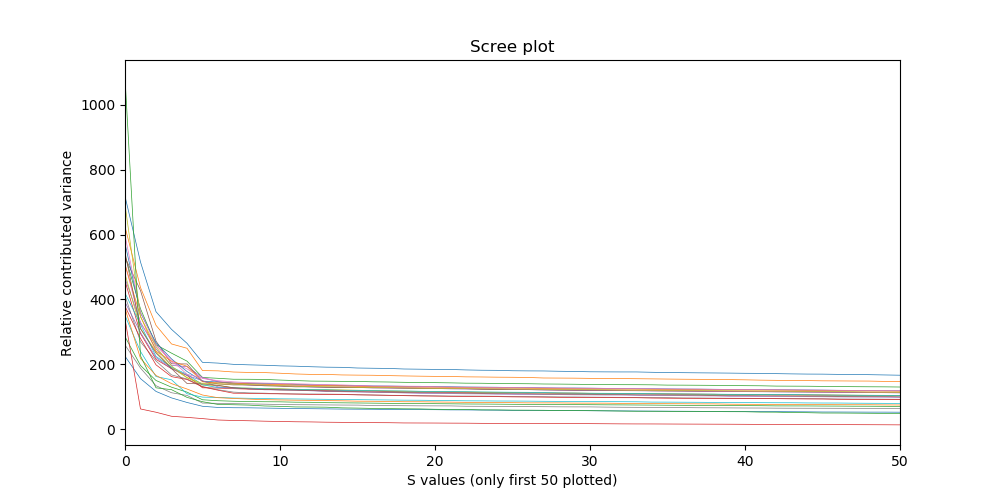

It's more like 5... we could use the elbow method, or go by eigenvalues... not sure if it would make that much difference.

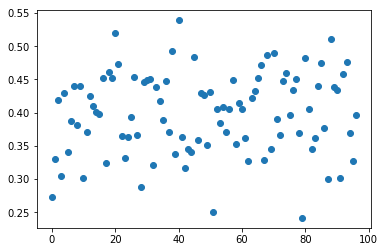

In [4]:
%matplotlib inline

import pylab as pl

fid = open('/data/sudregp/cnv/conifer/sd_values.txt', 'r')
sds = [float(line.rstrip().split('\t')[1]) for line in fid]
fid.close()
pl.plot(sds, 'o')
    

In [5]:
import numpy as np
[s for s in sds if s > (np.mean(sds) + 3*np.std(sds)) or 
                   s < (np.mean(sds) - 3*np.std(sds)) ]

[]

All samples look quite well-behaved. We could potentially remove those extremes, but it's probably overkill. Let's then focus on getting these results into PLINK, before we try different parameters. But this isn't as easy, because we need VCFs to determine denovo mutations... could I make these tabular formats into xcnv, and then use XHMM to convert it? No... it needs the DATA file...

# Filtering variants

Our big issue here is that we'll need to filter de novo calls by hand, as none of these new tools do denovo filtering, nor do they output VCF for us to use PSEQ. Let's write some scripts here, and then test them against what PSEQ reports on the XHMM data:

In [8]:
# for each trio
    # for each CNV in the child
        # if CNV start is not within any parents boundary AND
        # CNV end is not within any parents boundary
            # it's denovo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
# figure out who is who in each trio
import glob
ped_file = '/data/sudregp/cnv/simplex.ped'
wes_prefix = ['CLIA', 'CCGO', 'WPS']
trios = []
affected = []
controls = []
samples = []
famids = []
fid = open(ped_file, 'r')
for line in fid:
    famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
    if fa[:4] in wes_prefix and mo[:4] in wes_prefix and sid[:4] in wes_prefix:
        fam = {}
        fam['child'] = sid
        if aff == '1':
            affected.append(sid)
        else:
            controls.append(sid)
        fam['father'] = fa
        fam['mother'] = mo
        fam['famid'] = famid
        trios.append(fam)
        samples += [sid, fa, mo]
        famids.append(famid)
fid.close()
samples = set(samples)
famids = set(famids)

fid = open('/data/sudregp/cnv/kid_samples.txt', 'r')
good_kids = [line.rstrip() for line in fid]
fid.close()

In [9]:
fid = open('/data/sudregp/cnv/conifer/calls.txt', 'r')
cnvs = {}
for sample in samples:
    cnvs[sample] = []
for line in fid:
    if line.find('sampleID') < 0:
        sample, chr, start, end, cnvtype = line.rstrip().split('\t')
        cnvs[sample.split('.')[0]].append([chr, start, end, cnvtype])
fid.close()

In [15]:
inherited = {}
denovo = {}
for trio in trios:
    inherited[trio['child']] = []
    denovo[trio['child']] = []
    
# need to filter in chr and type first because ranges repeat for every chr,
# and inheritance is only true for the same type of CNV
for chr in ['chr%d' % d for d in range(1, 23)]:
    for cnvtype in ['dup', 'del']:
        for trio in trios:
            kid = [cnv for cnv in cnvs[trio['child']] if (cnv[0] == chr and
                                                          cnv[3] == cnvtype)]
            dad = [cnv for cnv in cnvs[trio['father']] if (cnv[0] == chr and
                                                          cnv[3] == cnvtype)]
            mom = [cnv for cnv in cnvs[trio['mother']] if (cnv[0] == chr and
                                                          cnv[3] == cnvtype)]
            for cnv in kid:
                is_inherited = False
                # if CNV start is not within any parents boundary AND
                #         CNV end is not within any parents boundary
                # it's denovo
                for pcnv in dad + mom:
                    if ((cnv[1] >= pcnv[1] or cnv[1] <= pcnv[2]) or
                        (cnv[2] >= pcnv[1] or cnv[2] <= pcnv[2])):
                        is_inherited = True
                if is_inherited:
                    inherited[trio['child']].append(cnv)
                else:
                    denovo[trio['child']].append(cnv)
        
        

In [22]:
for child in affected + controls:
    print len(inherited[child]), len(denovo[child]), len(cnvs[child])

31 2 35
46 1 48
48 3 51
33 5 39
41 2 45
28 1 29
23 2 26
41 4 47
31 2 33
22 7 29
23 1 25
38 3 41
27 2 29
55 1 56
33 1 34
35 4 40
24 0 24
5 2 7
32 1 33
37 6 43
28 1 29
25 2 27
64 2 67
28 10 38
39 2 42
51 3 56
28 3 34
34 5 39
18 4 22
46 5 51
33 4 37
17 9 26
11 4 15
13 4 17
33 3 37
45 8 55
55 5 62
32 1 33
62 0 63
30 2 32
64 7 72
52 1 55
32 2 34
31 2 36
32 2 38
1 1 2
45 2 48
50 0 51
44 3 47
40 2 44
20 6 26


** NEED TO CHECK THIS, BECAUSE CNVS CAN ONLY BE DENOVO OR INHERITED!!!! **